In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import math
import json
import numpy as np
import jax
import jax.numpy as jnp
import flax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import timecast as tc

from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
from timecast.learners import ARX
from timecast.utils.ar import historify

In [3]:
basins = pickle.load(open("../data/flood/meta.pkl", "rb"))["basins"]

In [4]:
basin = basins[0]

X = pickle.load(open("../data/flood/test/{}.pkl".format(basin), "rb"))
Y = pickle.load(open("../data/flood/base/{}.pkl".format(basin), "rb"))

In [24]:
from jax.config import config
config.update('jax_disable_jit', False)

In [159]:
%%timeit
def test_arx():
    import pickle
    import flax

    from timecast.learners import ARX, Parallel, Precomputed
    from timecast.learners import NewMixin

    from timecast.optim import GradientDescent
    from timecast.objectives import residual

    from timecast import tscan

    basin = basins[0]

    X = pickle.load(open("../data/flood/test/{}.pkl".format(basin), "rb"))
    Y = pickle.load(open("../data/flood/base/{}.pkl".format(basin), "rb"))
    history_len = 270

    Y_lstm = jnp.pad(jnp.array(Y.qsim), (history_len - 1, 0))
    Y = jnp.pad(jnp.array(Y.qobs), (history_len - 1, 0)).reshape(-1, 1)

    class FloodPredictor(NewMixin, flax.nn.Module):
        def apply(self, features, arr, history_len):
            lstm = Precomputed(x=features, arr=arr)
            arx = ARX(features=features, history_len=history_len, constrain=False)

            return [lstm, arx]

    model, state = FloodPredictor.new(shapes=[(1, 32)], arr=Y_lstm, history_len=history_len)
    optim_def = GradientDescent(learning_rate=10 ** -5)
    optimizer = optim_def.create(model)

    return tscan(X, Y, optimizer, state=state, objective=residual)

test_arx()

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


517 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [162]:
%%timeit
def test_ar():
    import pickle
    import flax

    from timecast.learners import AR, Parallel, Precomputed
    from timecast.learners import NewMixin

    from timecast.optim import GradientDescent
    from timecast.objectives import residual

    from timecast import tscan

    basin = basins[0]

    X = pickle.load(open("../data/flood/test/{}.pkl".format(basin), "rb"))
    Y = pickle.load(open("../data/flood/base/{}.pkl".format(basin), "rb"))
    history_len = 270

    X = X[history_len - 1:]
    Y_lstm = jnp.array(Y.qsim)
    Y = jnp.array(Y.qobs).reshape(-1, 1)

    class FloodPredictor(NewMixin, flax.nn.Module):
        def apply(self, features, arr, history_len):
            lstm = Precomputed(x=features, arr=arr)
            ar = AR(x=features, history_len=history_len, history=X[:history_len - 1])

            return [lstm, ar]

    model, state = FloodPredictor.new(shapes=[(1, 32)], arr=Y_lstm, history_len=history_len)
    optim_def = GradientDescent(learning_rate=10 ** -5)
    optimizer = optim_def.create(model)

    return tscan(X, Y, optimizer, state=state, objective=residual)

test_ar()

355 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
%%prun -D ar_vs_arx.pstats
def test_arx():
    import pickle
    import flax

    from timecast.learners import ARX, Parallel, Precomputed
    from timecast.learners import NewMixin

    from timecast.optim import GradientDescent
    from timecast.objectives import residual

    from timecast import tscan

    basin = basins[0]

    X = pickle.load(open("../data/flood/test/{}.pkl".format(basin), "rb"))
    Y = pickle.load(open("../data/flood/base/{}.pkl".format(basin), "rb"))
    history_len = 270

    Y_lstm = jnp.pad(jnp.array(Y.qsim), (history_len - 1, 0))
    Y = jnp.pad(jnp.array(Y.qobs), (history_len - 1, 0)).reshape(-1, 1)

    class FloodPredictor(NewMixin, flax.nn.Module):
        def apply(self, features, arr, history_len):
            lstm = Precomputed(x=features, arr=arr)
            arx = ARX(features=features, history_len=history_len, constrain=False)

            return [lstm, arx]

    model, state = FloodPredictor.new(shapes=[(1, 32)], arr=Y_lstm, history_len=history_len)
    optim_def = GradientDescent(learning_rate=10 ** -5)
    optimizer = optim_def.create(model)

    return tscan(X, Y, optimizer, state=state, objective=residual)

def test_ar():
    import pickle
    import flax

    from timecast.learners import AR, Parallel, Precomputed
    from timecast.learners import NewMixin

    from timecast.optim import GradientDescent
    from timecast.objectives import residual

    from timecast import tscan

    basin = basins[0]

    X = pickle.load(open("../data/flood/test/{}.pkl".format(basin), "rb"))
    Y = pickle.load(open("../data/flood/base/{}.pkl".format(basin), "rb"))
    history_len = 270

    X = X[history_len - 1:]
    Y_lstm = jnp.array(Y.qsim)
    Y = jnp.array(Y.qobs).reshape(-1, 1)

    class FloodPredictor(NewMixin, flax.nn.Module):
        def apply(self, features, arr, history_len):
            lstm = Precomputed(x=features, arr=arr)
            ar = AR(x=features, history_len=history_len, history=X[:history_len - 1])

            return [lstm, ar]

    model, state = FloodPredictor.new(shapes=[(1, 32)], arr=Y_lstm, history_len=history_len)
    optim_def = GradientDescent(learning_rate=10 ** -5)
    optimizer = optim_def.create(model)

    return tscan(X, Y, optimizer, state=state, objective=residual)

arx = test_arx()
ar = test_ar()

 
*** Profile stats marshalled to file 'ar_vs_arx.pstats'. 


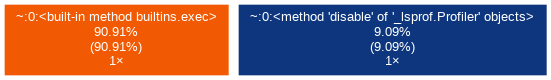

In [88]:
!gprof2dot -f pstats ar_vs_arx.pstats | dot -Tpng -o ar_vs_arx.png
Image(filename="ar_vs_arx.png")

In [109]:
%%prun -D arx.pstats -q

import pickle
import flax

from timecast.learners import ARX, Parallel, Precomputed
from timecast.learners import NewMixin

from timecast.optim import GradientDescent
from timecast.objectives import residual

from timecast import tscan

basin = basins[0]

X = pickle.load(open("../data/flood/test/{}.pkl".format(basin), "rb"))
Y = pickle.load(open("../data/flood/base/{}.pkl".format(basin), "rb"))
history_len = 270

Y_lstm = jnp.pad(jnp.array(Y.qsim), (history_len - 1, 0))
Y = jnp.pad(jnp.array(Y.qobs), (history_len - 1, 0)).reshape(-1, 1)

class FloodPredictor(NewMixin, flax.nn.Module):
    def apply(self, features, arr, history_len):
        lstm = Precomputed(x=features, arr=arr)
        arx = ARX(features=features, history_len=history_len, constrain=False)

        return [lstm, arx]

model, state = FloodPredictor.new(shapes=[(1, 32)], arr=Y_lstm, history_len=history_len)
optim_def = GradientDescent(learning_rate=10 ** -5)
optimizer = optim_def.create(model)

results = tscan(X, Y, optimizer, state=state, objective=residual)

 
*** Profile stats marshalled to file 'arx.pstats'. 


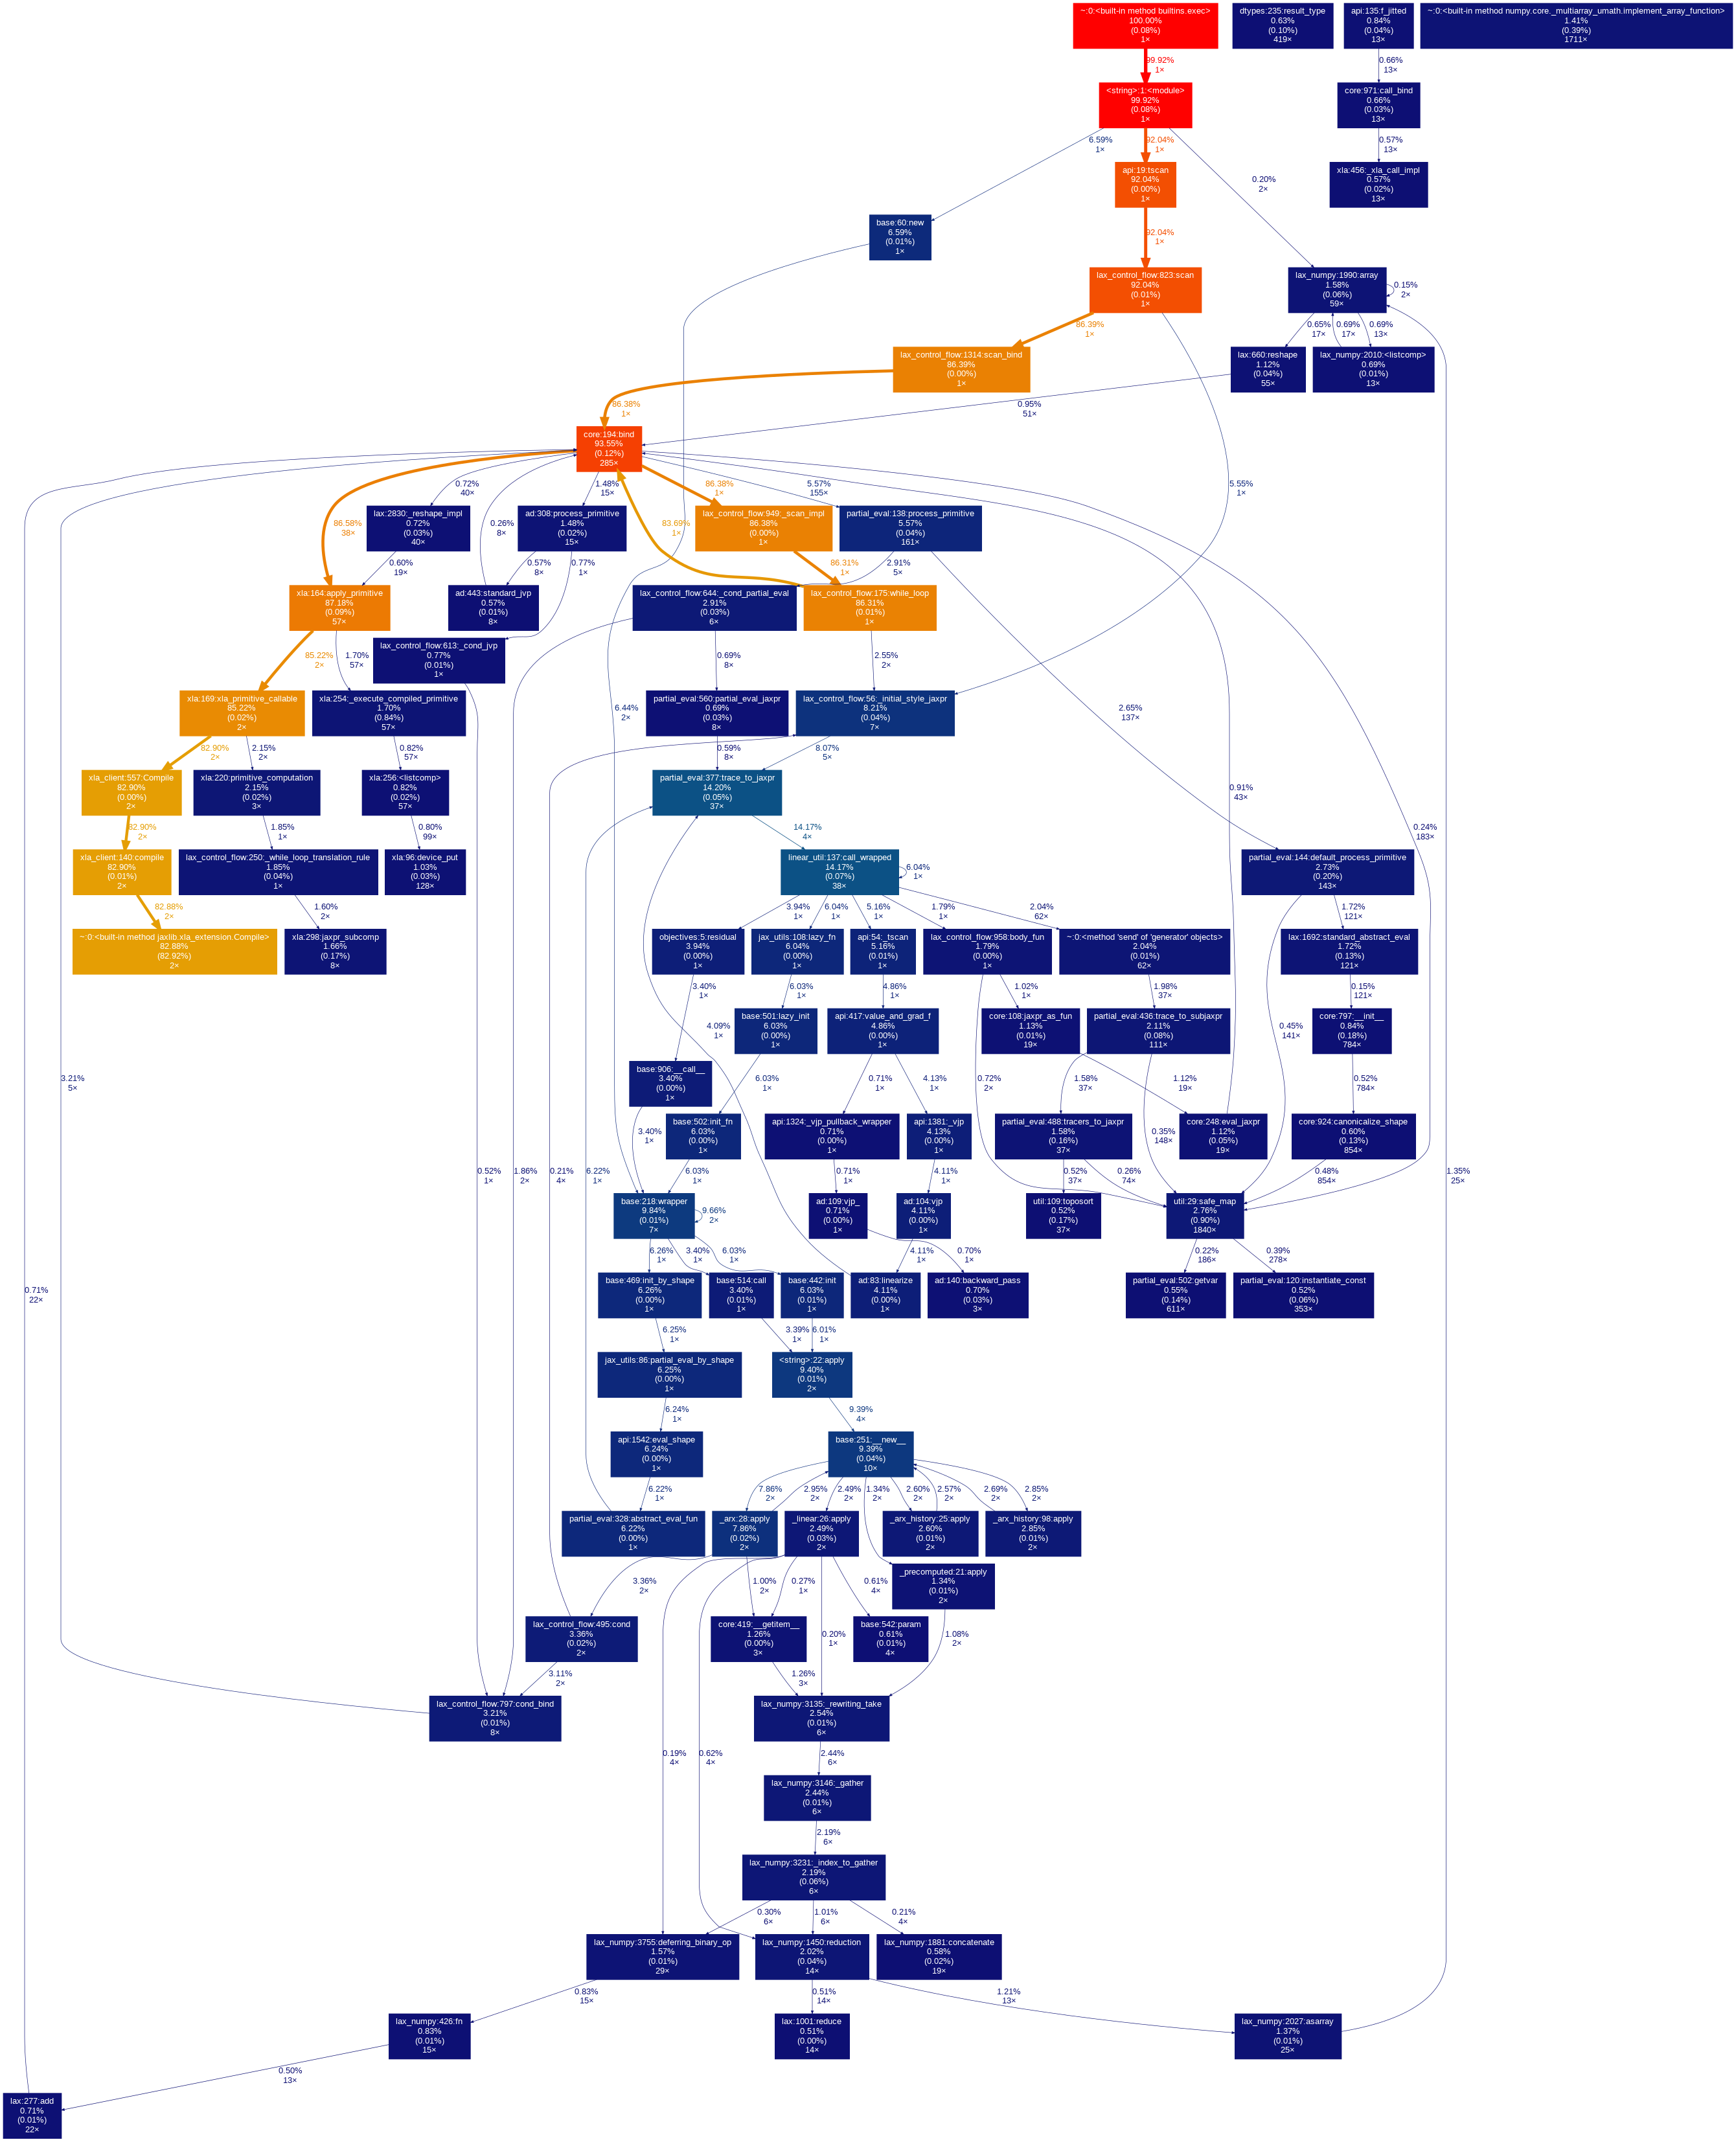

In [110]:
!gprof2dot -f pstats arx.pstats | dot -Tpng -o arx.png
Image(filename="arx.png")

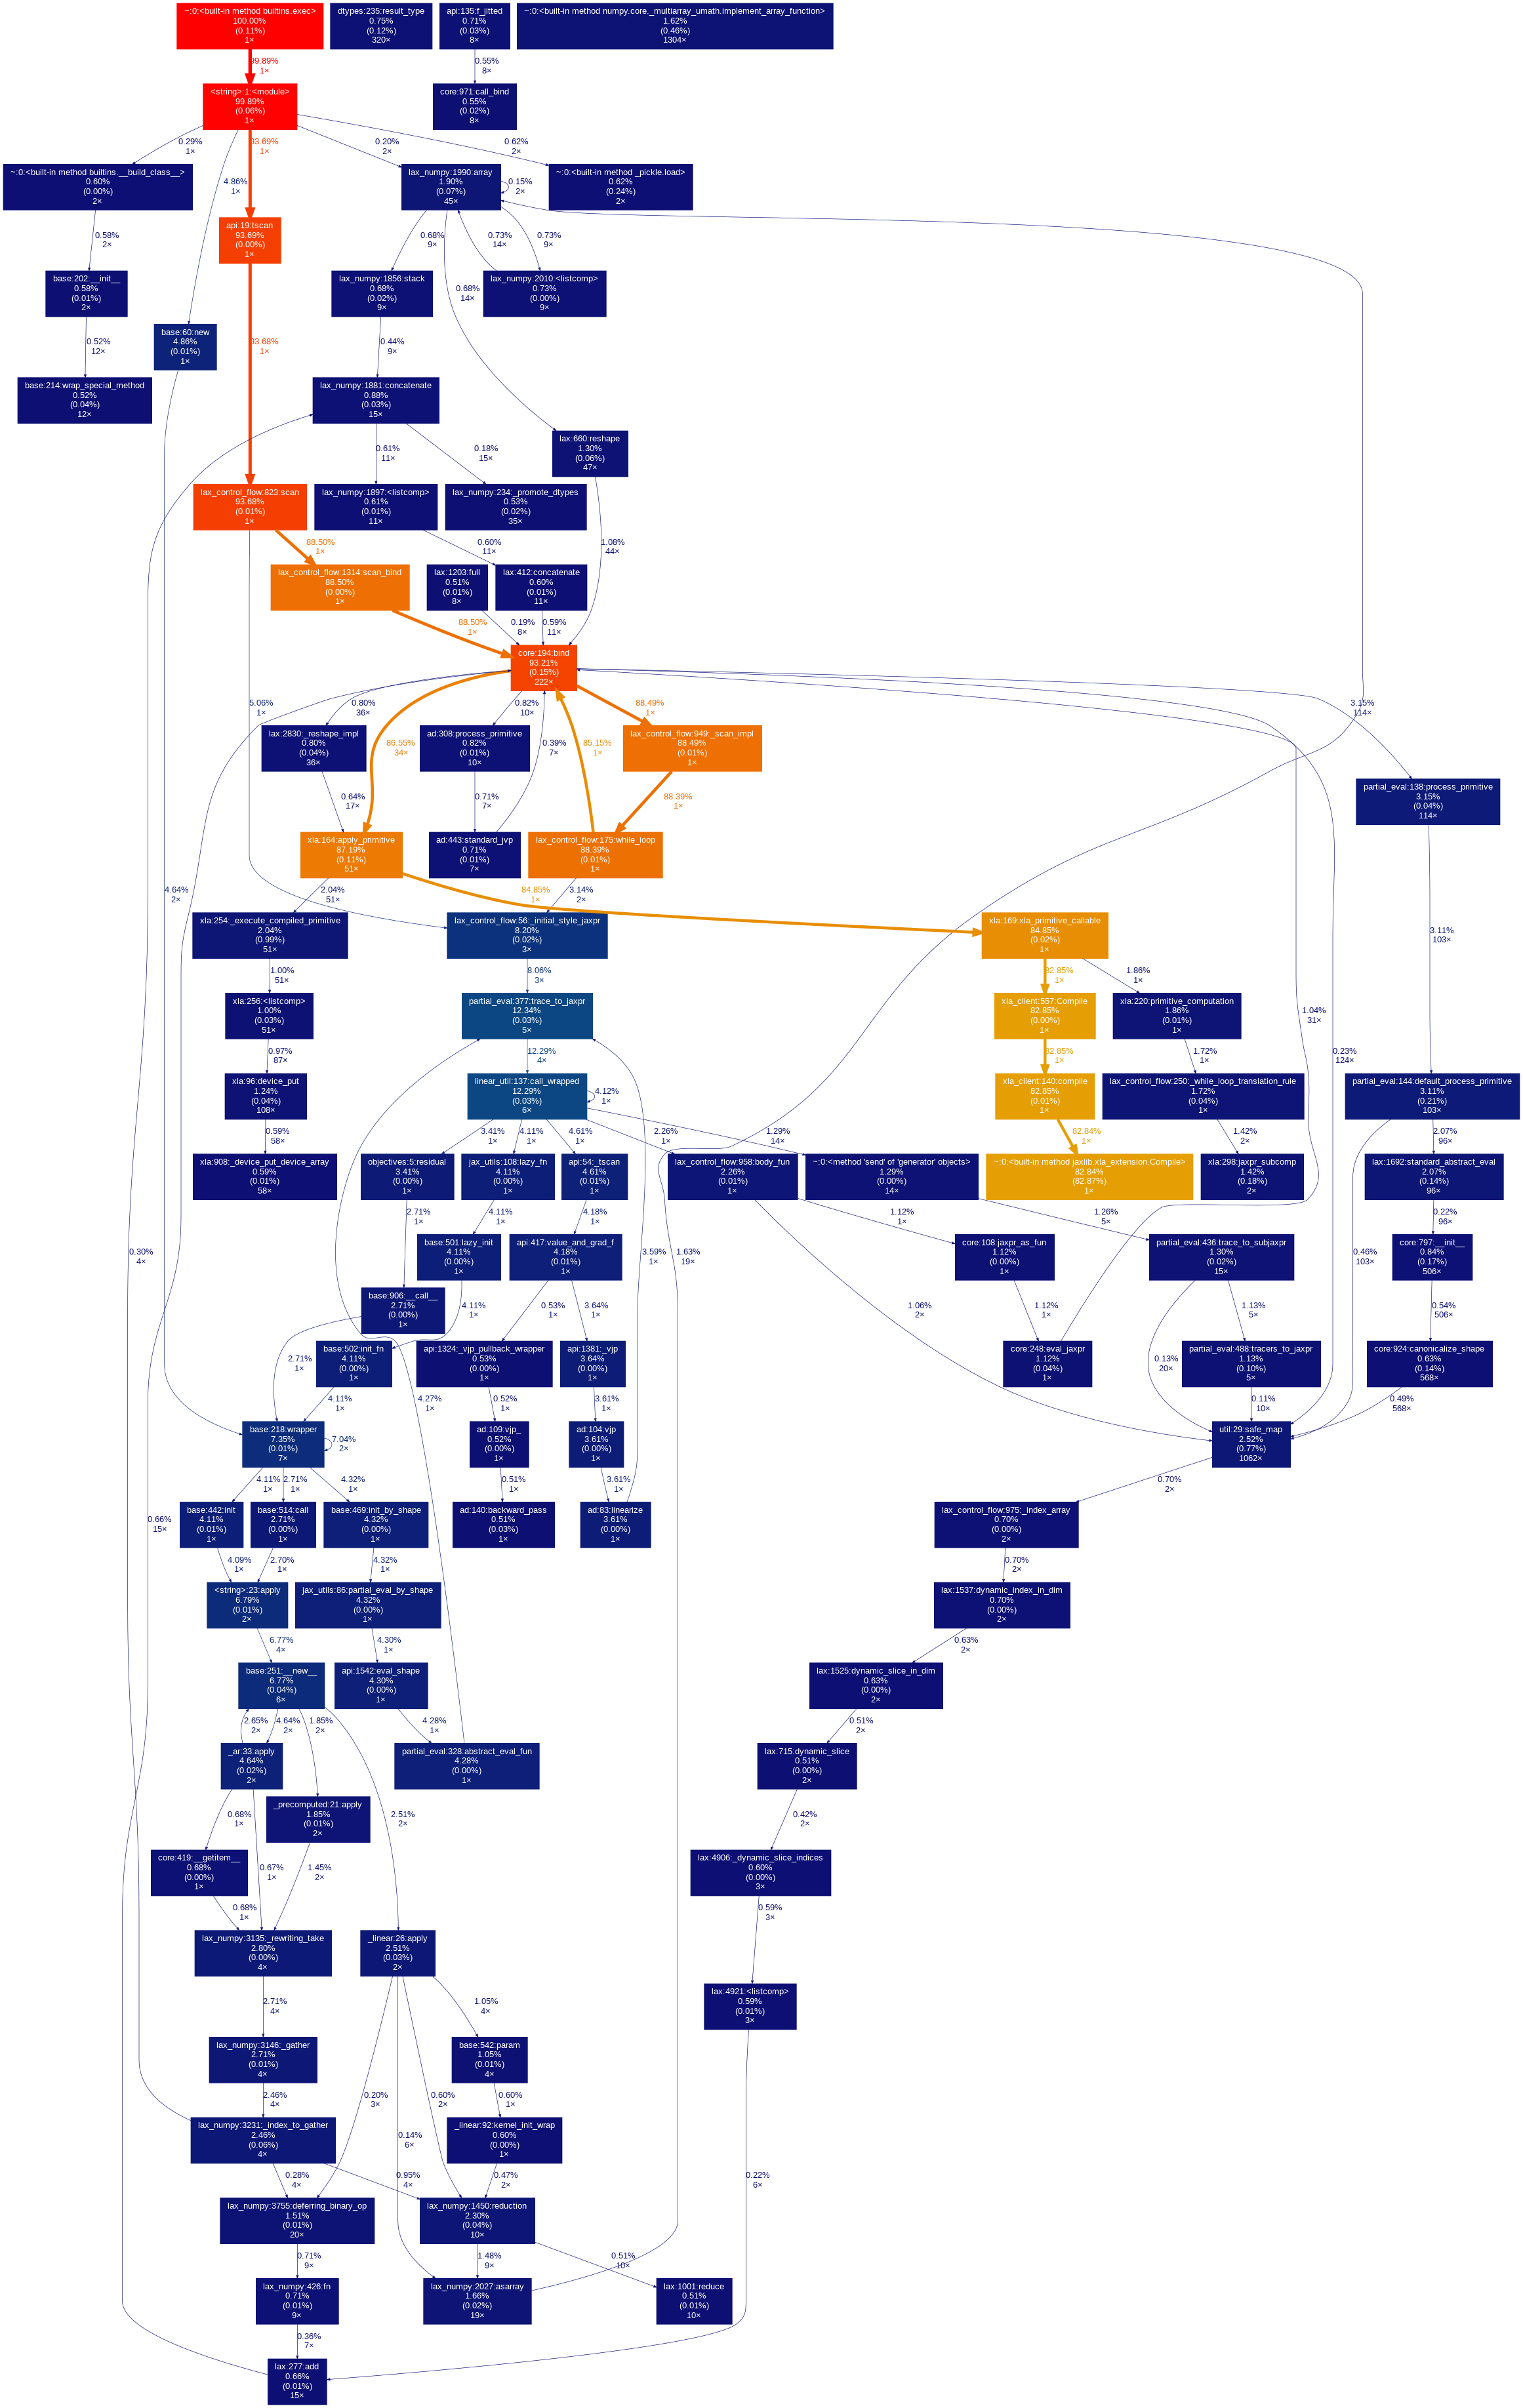

In [108]:
!gprof2dot -f pstats ar.pstats | dot -Tpng -o ar.png
Image(filename="ar.png")

In [ ]:
np.pad(a, (10, 0))

In [ ]:
from timecast.optim import GradientDescent

In [ ]:
optim_def = GradientDescent(learning_rate=10 ** -5)

In [ ]:
optimizer = optim_def.create(model)

In [ ]:
model.params

In [ ]:
def func(model, truth, targets=None, features=None):
    y_hat = model(targets, features)
    return jnp.square(truth - y_hat).mean(), y_hat

with flax.nn.stateful(state) as state:
    (loss, y_hat), gradient = jax.value_and_grad(func, has_aux=True)(optimizer.target,
                                                                     jnp.ones((1, 2)),
                                                                     jax.random.uniform(tc.utils.random.generate_key(), (1, 2)),
                                                                     jax.random.uniform(tc.utils.random.generate_key(), (1, 1)))
    optimizer = optimizer.apply_gradient(gradient)

In [ ]:
gradient

In [ ]:
y_hat

In [ ]:
optimizer.target.params

In [ ]:
inputs = jax.random.uniform(jax.random.PRNGKey(2), (1, 2))
with flax.nn.stateful(state) as state:
    result = optimizer.target(inputs)

In [ ]:
result

(batch, history, input1, input2) x (history, input1, input2, output1, output2) = (batch, input1, input2, output1, output2)

bias: (batch, output1, input1, input2, output2)

In [ ]:
sorted([4,1,2])

In [ ]:
jnp.tensordot(jnp.ones((3, 2, 4)), jnp.ones((2, 1, 5)), axes=[(1,), (0,)]).shape

In [134]:
a = jnp.array(np.random.rand(10, 4))

In [135]:
# With index
%timeit historify(a, history_len = 4).shape

2.82 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [136]:
# Without index
%timeit historify(a, history_len = 4).shape

1.1 ms ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [137]:
history_len = 4
offset = 0
num_histories = a.shape[0] - offset - history_len + 1

In [138]:
num_histories

7

In [147]:
def rolling_window(X, history_len):
    """Directly taken from Erik Rigtorp's post to numpy-discussion.
    <http://www.mail-archive.com/numpy-discussion@scipy.org/msg29450.html>"""
    X = np.asarray(X)
    if history_len < 1:
       raise ValueError("`window` must be at least 1.")
    if history_len > X.shape[0]:
       raise ValueError("`window` is too long.")
    shape = (X.shape[0] - history_len + 1, history_len) + a.shape[1:]
    strides = (X.strides[0],) + X.strides
    return jnp.asarray(np.lib.stride_tricks.as_strided(X, shape=shape, strides=strides))

In [148]:
%%timeit
jnp.asarray(rolling_window(np.asarray(a), 4))

81.8 µs ± 7.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [158]:
%timeit historify(a, history_len = 4)

67.1 µs ± 328 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


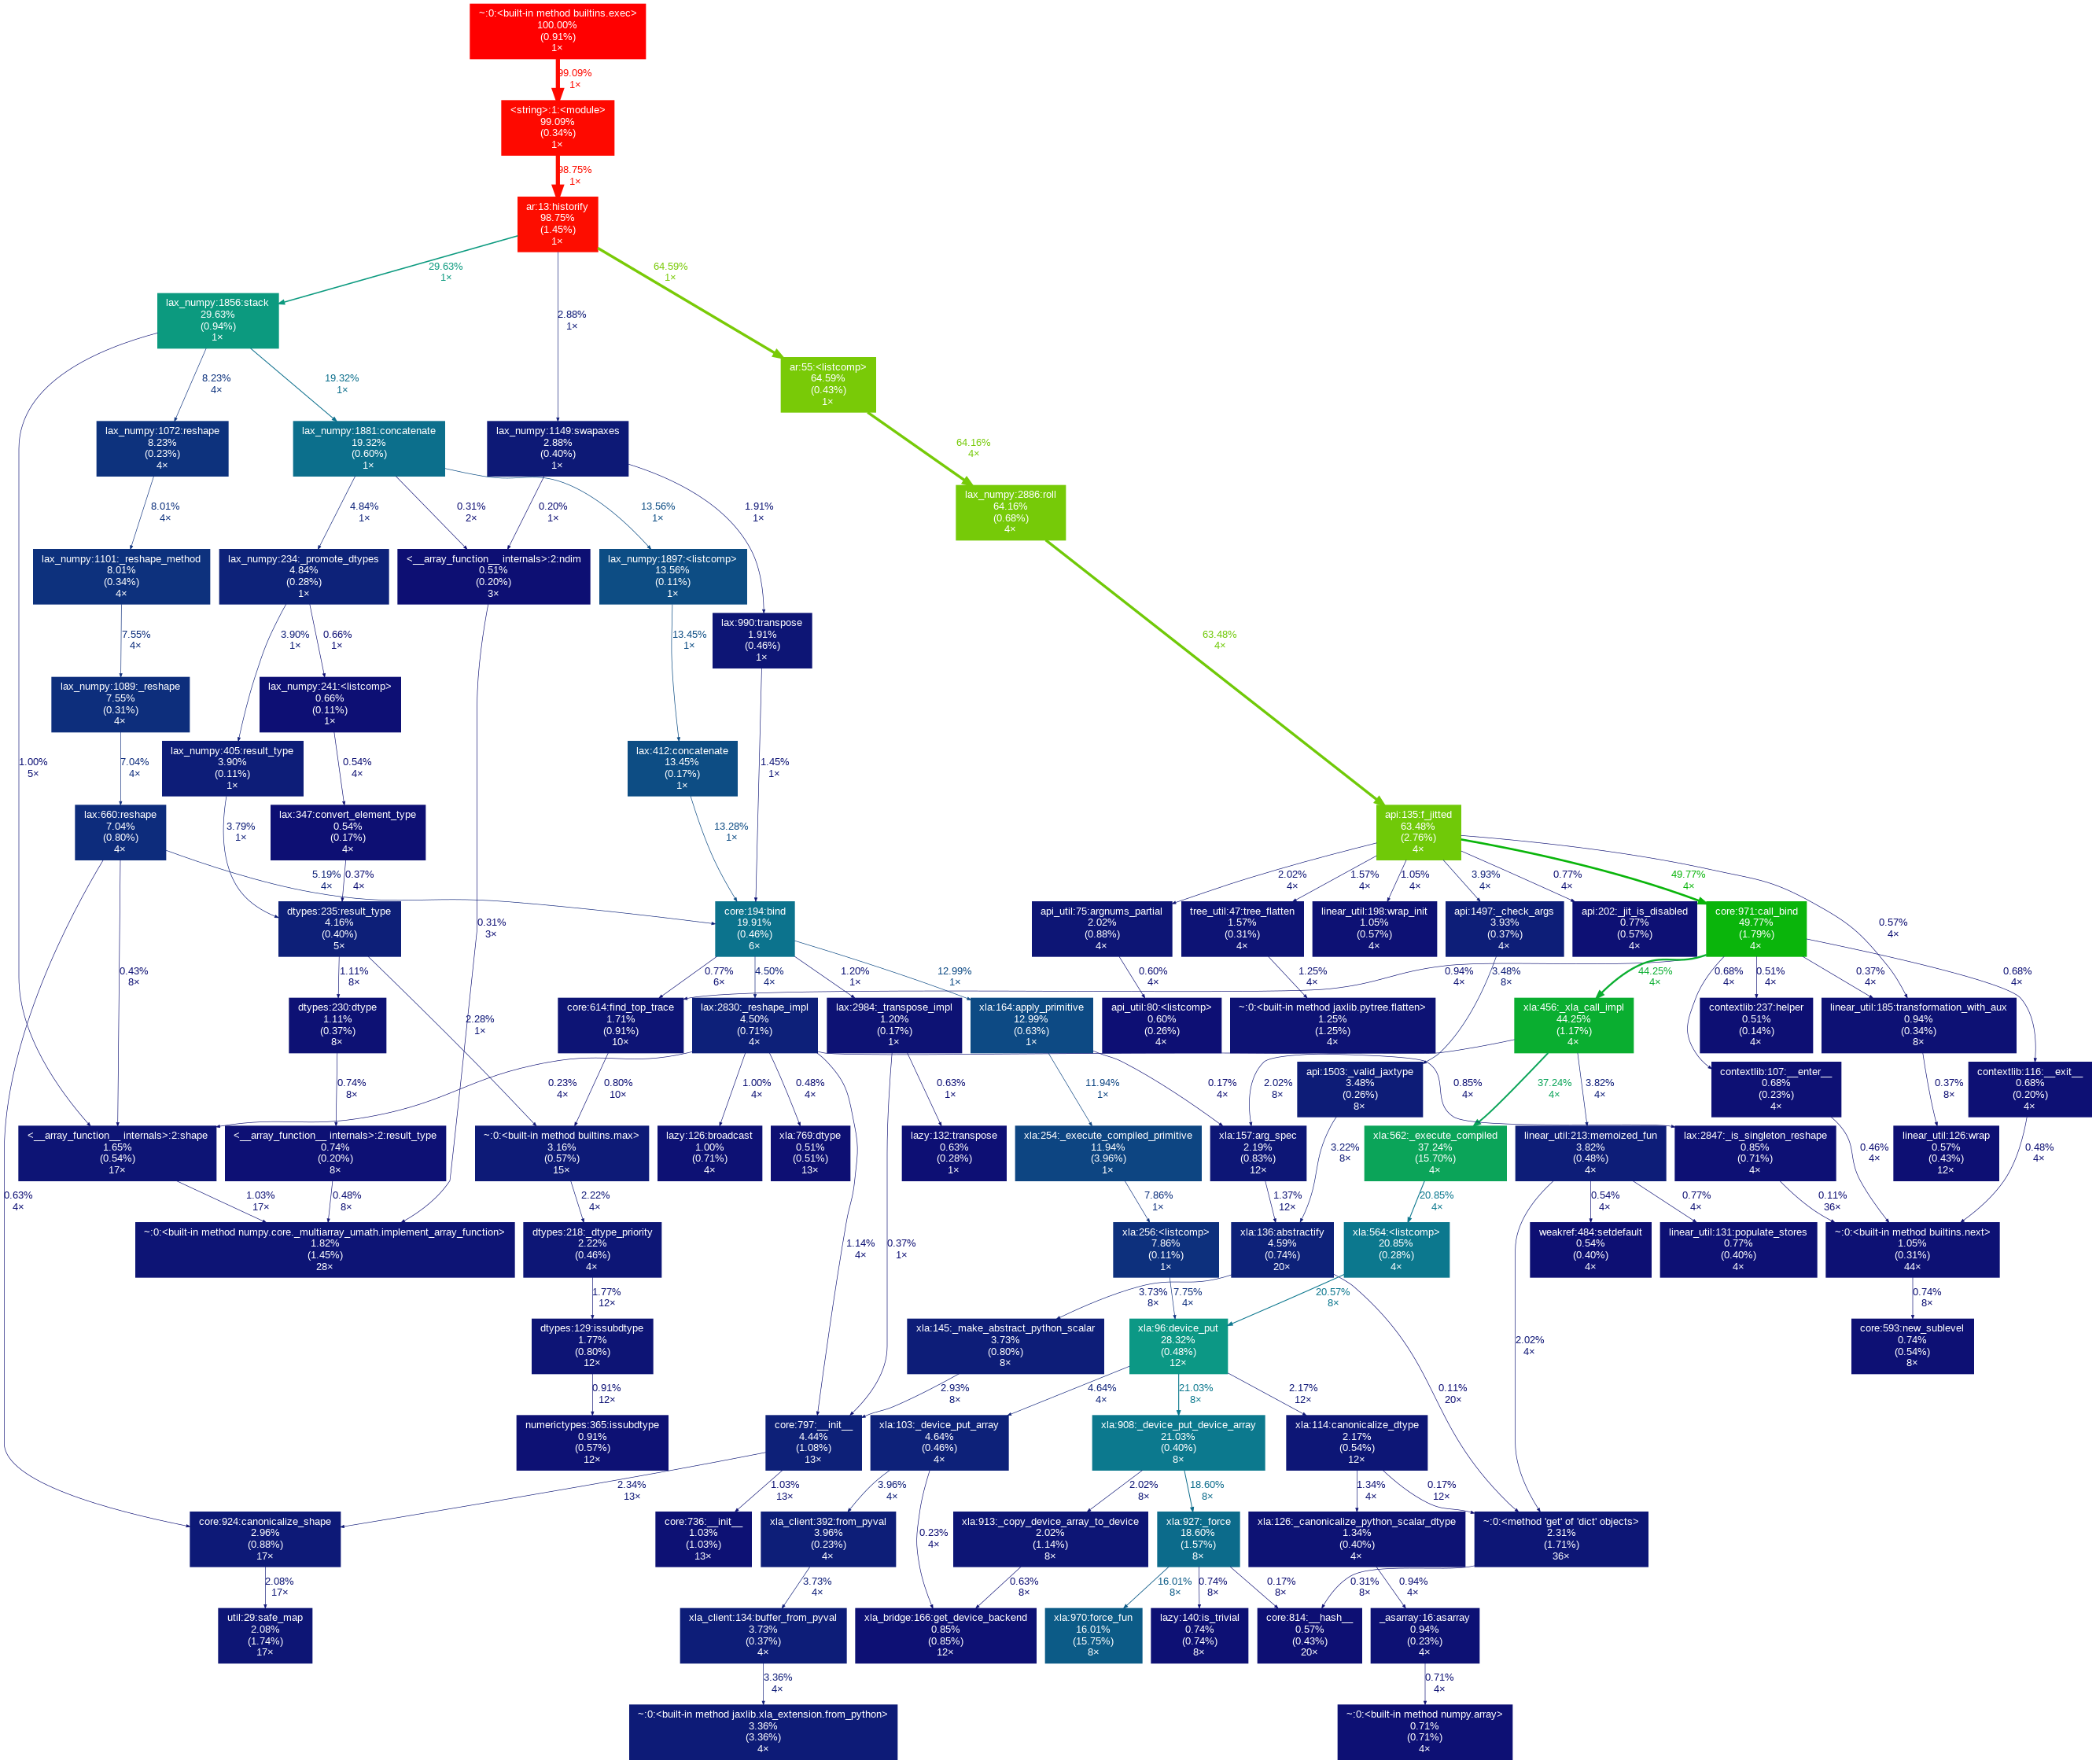

In [120]:
!gprof2dot -f pstats historify.pstats | dot -Tpng -o historify.png
Image(filename="historify.png")

In [ ]:
a.reshape((1, -1))

Loop 0
- targets: 0 to H
- features: 0 to H

next
- targets: 0 to H
- features: 1 to H + 1

finally
- targets: 1 to H + 1
- features: 1 to H + 1

In [ ]:
def my_func(x):
    return x

c = jax.xla_computation(my_func)(1.0)
print_opts = jax.lib.xla_client._xla.HloPrintOptions.short_parsable()
local_backend = jax.lib.xla_client.get_local_backend('cpu')
out = local_backend.compile(c)
print(out.hlo_modules()[0].to_string(print_opts))